## <font color='green'>Problem 1: last part: efficientnet</font>

## Importing libraries:

In [1]:
import numpy as np
import pandas as pd
import copy
import time

In [8]:
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import PIL
import sys
import math
from matplotlib.pyplot import figure
import os
import cv2 
from google.colab.patches import cv2_imshow
import random

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from keras import backend as k
import tensorflow_probability as tfp
from tensorflow.keras import layers

In [5]:
from sklearn import preprocessing

## Importing pre trained efficentnet B0:

In [6]:
from tensorflow.keras.applications import EfficientNetB0

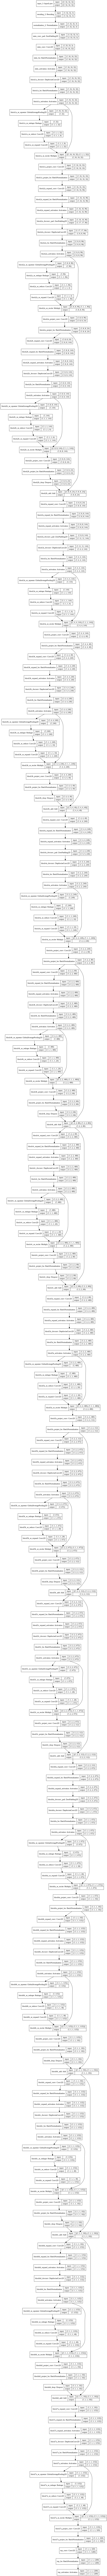

In [10]:
Effnet_input = (32, 32, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape = Effnet_input)
plot_model(conv_base, to_file='conv_base.png', show_shapes=True, show_layer_names=True)

## building Ecoder:

In [13]:
# sampling layer
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch_size_ = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch_size_, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 32, 32, 3)    7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 33, 33, 3)    0           normalization_2[0][0]            
____________________________________________________________________________________________

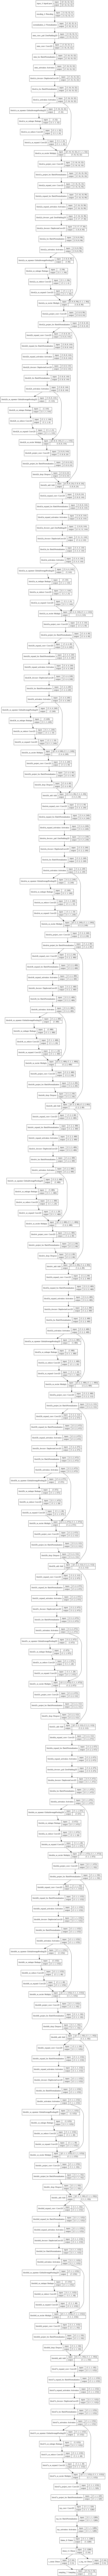

In [24]:
latent_dim = 6
EfNet_output = conv_base.output
x = layers.Flatten()(EfNet_output)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_sampled = Sampling()([z_mean, z_log_var])
encoder = keras.Model(conv_base.input, [z_mean, z_log_var, z_sampled], name="encoder")
encoder.summary()
conv_base.trainable = False
plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)

## Defining decoder:

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 3136)              21952     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 77,633
Trainable params: 77,633
Non-trainable params: 0
_______________________________________________________

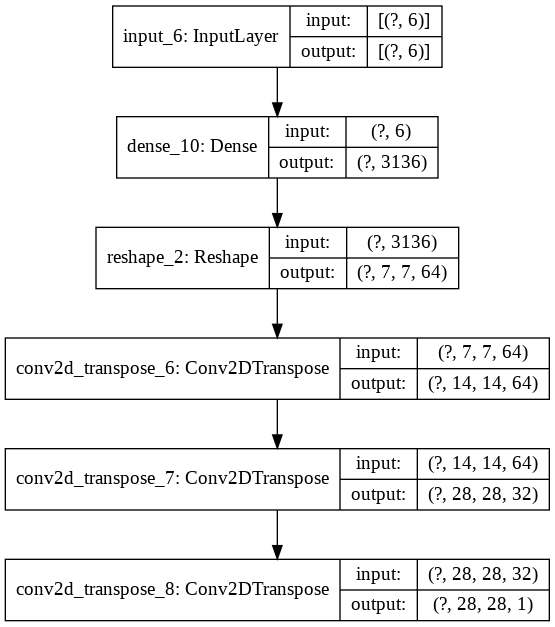

In [23]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, kernel_size=3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, kernel_size=3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, kernel_size=3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()
plot_model(decoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)

## Class VAE:

In [36]:
def generate_and_save_images(model, test_sample):
  mean, logvar, z = model.encoder(test_sample)
  predictions = model.decoder(z)
  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.show()

def progress_bar(count, total, loss_sting):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))
    percents = min(round(100.0 * count / float(total), 1), 100)
    bar = '=' * filled_len + '>>' + '.' * (bar_len - filled_len-1) 
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("[%-20s] %d%%" % (bar, percents) + loss_string)
    sys.stdout.flush()

class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder


def compute_loss_VAE(model, data):
  encoder = model.encoder
  decoder = model.decoder

  z_mean, z_log_var, z = encoder(data)
  reconstruction = decoder(z)
  reconstruction_loss = tf.reduce_mean(
      keras.losses.binary_crossentropy(data, reconstruction)
      
  )
  reconstruction_loss = reconstruction_loss * (1*28*28)
  KL_loss = ( -1 - 0.5 * z_log_var + z_mean**2 + tf.exp(z_log_var) ) / 2
  KL_loss = tf.reduce_mean(KL_loss)
  return KL_loss, reconstruction_loss 

def train_step(model, optimizer, data):
  if isinstance(data, tuple):
    data = data[0]
  
  with tf.GradientTape() as tape:
    KL_loss, reconstruction_loss = compute_loss_VAE(model, data)
    total_loss = KL_loss + reconstruction_loss

  grads = tape.gradient(total_loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  return {
      "total_loss": total_loss,
      "reconstruction_loss": reconstruction_loss,
      "kl_loss": KL_loss,
  }

In [32]:
BATCH_SIZE = 128
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
paddings = tf.constant([[2, 2], [2, 2]])
three_channel_train_images = np.full(tuple([train_images.shape[0]] +list(Effnet_input)), 255.0)
three_channel_test_images = np.full(tuple([test_images.shape[0]] +list(Effnet_input)), 255.0)
for i, s in enumerate(train_images):
    x = tf.pad(s, paddings, "CONSTANT")
    three_channel_train_images[i] = cv2.cvtColor(x.numpy(), cv2.COLOR_GRAY2RGB) 
for i, s in enumerate(test_images):
    x = tf.pad(s, paddings, "CONSTANT")
    three_channel_test_images[i] = cv2.cvtColor(x.numpy(), cv2.COLOR_GRAY2RGB)

train_images = three_channel_train_images.astype('float32') / 255
test_images =three_channel_test_images.astype('float32') / 255
  

In [38]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                .shuffle(train_images.shape[0]).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_images.shape[0]).batch(BATCH_SIZE))



num_examples_to_generate = 16
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [39]:
epochs = 10
lr =  0.002
history = {"train_loss":[], "test_loss":[]}
model = VAE(encoder, decoder)
generate_and_save_images(model, test_sample)
for epoch in range(1, epochs + 1):
  print("epoch:" + str(epoch) + "/" + str(epochs))
  start_time = time.time()
  all_losses_average = { "total_loss": [0, 0], "reconstruction_loss": [0, 0], "kl_loss": [0, 0] }

  optimizer = keras.optimizers.Adam(lr/epoch)
  for train_x in train_dataset:
    train_step_history = train_step(model, optimizer, train_x)

    loss_string = " time: " + str((time.time() - start_time) / 60 ) + "   ,"
    for key in train_step_history.keys():
      all_losses_average[key][0] = ( all_losses_average[key][0] * all_losses_average[key][1] + train_step_history[key].numpy() ) / ( all_losses_average[key][1] + 1 )
      all_losses_average[key][1] = all_losses_average[key][1] + 1
      loss_string = loss_string + key + ": " + str(all_losses_average[key][0]) + "   , "
    progress_bar(all_losses_average[key][1], int(train_images.shape[0] / BATCH_SIZE), loss_string)
  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    KL_loss, reconstruction_loss = compute_loss_VAE(model, test_x)
    loss(KL_loss + reconstruction_loss)
  test_loss = loss.result()
  print('test total loss: {}'.format(test_loss))
  generate_and_save_images(model, test_sample)
  history["train_loss"].append(all_losses_average["total_loss"])
  history["test_loss"].append(test_loss)
